In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from scipy import stats

In [2]:
import logging
from logging import getLogger
import mlflow
from modelling.config import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///Users/valentin/neuefische/ds-capstone-alzheimers-/modelling/mlruns/1', experiment_id='1', lifecycle_stage='active', name='alzbusters_2D_CNN_MRI', tags={}>

In [3]:
logger = logging.getLogger()
logging.basicConfig(format="%(asctime)s: %(message)s")
logging.getLogger("pyhive").setLevel(logging.CRITICAL)  # avoid excessive logs
logger.setLevel(logging.INFO)

In [4]:
from preprocessing.getdata import *

# load csv_file
logger.info(f"Loading OASIS-csv, drop_young=True, drop_contradictions=True")
df = get_csvdata(drop_young=True, drop_contradictions=True)


#split dataframe into train and test
logger.info("Train test split on dataframe")
dfTrain, dfTest, y_train, y_test = train_test_split(df, df['CDR'], stratify = df['CDR'], random_state=42)



2022-08-24 12:35:13,940: Loading OASIS-csv, drop_young=True, drop_contradictions=True
2022-08-24 12:35:13,945: Train test split on dataframe


In [5]:
logger.info("empty training_history instantiated")
training_history= {}
test_performance= []

2022-08-24 12:35:13,967: empty training_history instantiated


In [6]:
# load image data (N slices above and below the plane (m), suggested by the datasource)
# standard values for m are 95 for dim=0, 110 for dim=1, 90 for dim=2


N, d, m, dim, norm, file = 0, 1, 90, 2, True, "masked"
logger.info(f"Loading 2D-OASIS train data: N,d,m,dim,norm,file={N},{d},{m},{dim},{norm},{file}")
X_train = get_slices(dfTrain['ID'], N=N, d=d, m=m, dim=dim, normalize=norm, file=file)

#number of slices for the test data
Ntest=0
logger.info(f"Loading 2D-OASIS test data: Ntest,d,m,dim,norm,file={Ntest},{d},{m},{dim},{norm},{file}")
X_test = get_slices(dfTest['ID'], m=m, d=d, dim=dim, N=Ntest, normalize=norm, file=file)

#expand y_train to the same length as X_train
y_train = y_train.repeat(1+2*N) 

data_params = f"N,d,m,dim,Ntest,norm,file={N},{d},{m},{dim},{Ntest},{norm},{file}"
mlflow.log_params(data_params)

2022-08-24 12:35:16,380: Loading 2D-OASIS train data: N,d,m,dim,norm,file=0,1,90,2,True,masked
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 12:35:16,385: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 12:35:16,387: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 12:35:16,559: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 12:35:16,560: very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2022-08-24 12:35:16,661: very large origin values relative to dims; leaving as set, ignoring f

AttributeError: 'str' object has no attribute 'items'

In [7]:
HEIGHT = X_train.shape[1]
WIDTH = X_train.shape[2]

In [8]:
'''model = Sequential()
model_name = "CNN_8-16"
logger.info(f"CNN model instantiated: {model_name}")
# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Dropout(0.2))
model.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())'''



'model = Sequential()\nmodel_name = "CNN_8-16"\nlogger.info(f"CNN model instantiated: {model_name}")\n# layers\nmodel.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name=\'image\'))\nmodel.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))\nmodel.add(Conv2D(8, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))\nmodel.add(MaxPooling2D(pool_size=[2, 2], strides=2))\n#model.add(Dropout(0.2))\nmodel.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))\nmodel.add(Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=keras.regularizers.l2(l=0.01)))\nmodel.add(MaxPooling2D(pool_size=[2, 2], strides=2))\n#model.add(Dropout(0.2))\nmodel.add(Flatten())\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units=64, activation="relu", kernel_regularizer=\'l2\'))\nmodel.add(Dense(units = 1, kernel_initializer = \'uniform\', activation = \'sigmoid\'))\n\nopt

In [9]:
model = Sequential()
model_name = "CNN_8-16_lessReg"
logger.info(f"CNN model instantiated: {model_name}")
# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(8, 3, activation="relu", padding="same"))
model.add(Conv2D(8, 3, activation="relu", padding="same"))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(Conv2D(16, 3, activation="relu", padding="same"))
#model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
#model.add(Conv2D(32, 3, activation="relu", padding="same"))
#model.add(Conv2D(32, 3, activation="relu", padding="same"))
#model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2))
model.add(Flatten())
model.add(Dense(units=64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy', 
    metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())


2022-08-24 12:27:12.357023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-24 12:27:12.358088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-24 12:27:12,390: CNN model instantiated: CNN_8-16_lessReg


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 104, 8)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 104, 16)       1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 88, 104, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 52, 1

In [10]:
'''model = Sequential()
model_name = "VGG16"
logger.info(f"CNN model instantiated: {model_name}")
# layers
model.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name='image'))
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(Conv2D(128, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(Conv2D(256, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(Conv2D(512, 3, activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])#, keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())'''

'model = Sequential()\nmodel_name = "VGG16"\nlogger.info(f"CNN model instantiated: {model_name}")\n# layers\nmodel.add(InputLayer(input_shape=[HEIGHT, WIDTH, 1], name=\'image\'))\nmodel.add(Conv2D(64, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(64, 3, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\nmodel.add(Conv2D(128, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(128, 3, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\nmodel.add(Conv2D(256, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(256, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(256, 3, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\nmodel.add(Conv2D(512, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(512, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(512, 3, activation="relu", padding="same"))\nmodel.add(MaxPooling2D())\nmodel.add(Conv2D(512, 3, activation="relu", padding="same"))\nmodel.add(Conv2D(512, 3, activat

In [11]:
BATCH_SIZE= 32
VAL_SPLIT= 0.2
EPOCHS=25
logger.info(f"Fitting model and storing history: batch_size={BATCH_SIZE},validation_split={VAL_SPLIT},epochs={EPOCHS}")
training_history[model_name+data_params] = model.fit(X_train, y_train, batch_size = BATCH_SIZE, validation_split=VAL_SPLIT, epochs = EPOCHS)

2022-08-24 12:27:12,666: Fitting model and storing history: batch_size=32,validation_split=0.2,epochs=25


Epoch 1/25


2022-08-24 12:27:12.790786: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-24 12:27:13.260995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 202ms/step - loss: 1.6676 - accuracy: 0.5093 - val_loss: 1.1476 - val_accuracy: 0.3929
Epoch 2/25


2022-08-24 12:27:14.181476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 81ms/step - loss: 1.0028 - accuracy: 0.5278 - val_loss: 0.8416 - val_accuracy: 0.3929
Epoch 3/25
4/4 [==============================] - 0s 82ms/step - loss: 0.7799 - accuracy: 0.5278 - val_loss: 0.7782 - val_accuracy: 0.3929
Epoch 4/25
4/4 [==============================] - 0s 75ms/step - loss: 0.7472 - accuracy: 0.5278 - val_loss: 0.7632 - val_accuracy: 0.3929
Epoch 5/25
4/4 [==============================] - 0s 73ms/step - loss: 0.7598 - accuracy: 0.5278 - val_loss: 0.7674 - val_accuracy: 0.3929
Epoch 6/25
4/4 [==============================] - 0s 75ms/step - loss: 0.7546 - accuracy: 0.5278 - val_loss: 0.7491 - val_accuracy: 0.3929
Epoch 7/25
4/4 [==============================] - 0s 90ms/step - loss: 0.7323 - accuracy: 0.5278 - val_loss: 0.7284 - val_accuracy: 0.3929
Epoch 8/25
4/4 [==============================] - 0s 76ms/step - loss: 0.7100 - accuracy: 0.5278 - val_loss: 0.7112 - val_accuracy: 0.3929
Epoch 9/25
4/4 [======================

In [12]:
# prediction of outcomes and conversion to binary
logger.info("Predicting on Xtest")
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs>0.5).astype(int)

2022-08-24 12:27:21,739: Predicting on Xtest
2022-08-24 12:27:21.870857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [13]:
# reshape is necessary if X_test also consists of multiple slices per sample

if Ntest != 0:
    test_length, slices_per_test_sample = dfTest.shape[0], int(y_pred.shape[0]/dfTest.shape[0])

    l = []
    for i in range(test_length):
        for j in np.where(y_pred.reshape((test_length,slices_per_test_sample))[i]==y_test.values[i])[0]:
            l.append(j)

    for i in range(12):
        print(i, l.count(i))

    y_pred = np.array(stats.mode(y_pred.reshape((test_length,slices_per_test_sample)), axis=1, keepdims=False))[0]

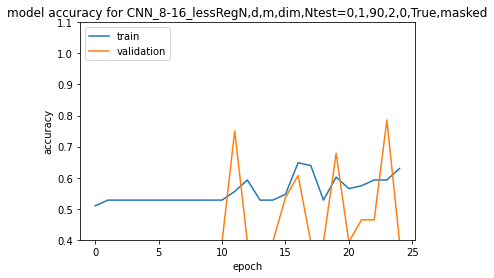

In [14]:
# summarize history for accuracy
plt.plot(training_history[model_name+data_params].history['accuracy'])
plt.plot(training_history[model_name+data_params].history['val_accuracy'])
plt.title(f"model accuracy for "+model_name+data_params)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.4,1.1])
plt.show()

In [15]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

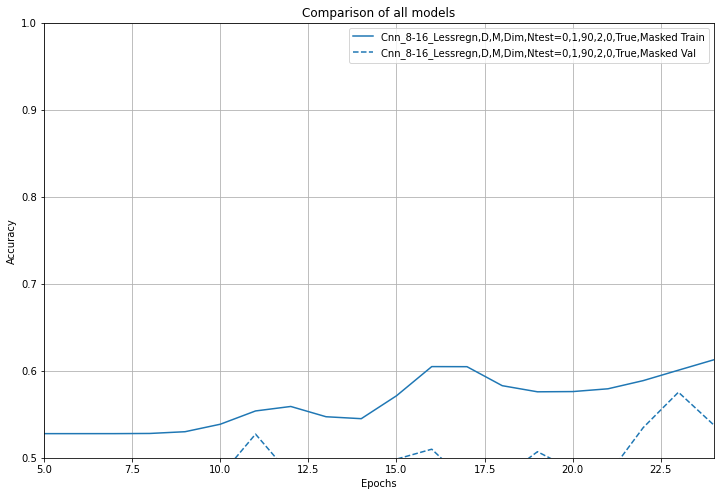

In [16]:
# Instantiate HistoryPlotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

# Plot results of all models

plt.figure(figsize=(12,8)) 
plotter.plot(training_history)
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 1])
plt.xlabel('Epochs')
plt.title('Comparison of all models')
plt.legend(loc='upper right')
plt.savefig("../models/Valle_CNN1_comparison_2.png");

accuracy:  0.48
recall:  0.0
precision:  0.0


,model,data,accuracy,recall,precision
0,CNN_8-16_lessReg,"N,d,m,dim,Ntest=0,1,90,2,0,True,masked",0.48,0.0,0.0


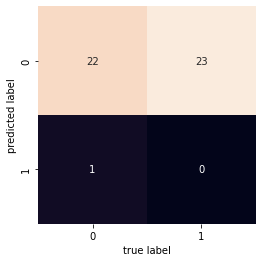

In [17]:
accuracy_score(y_test, y_pred)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

test_performance.append((model_name, data_params, accuracy_score(y_test, y_pred.round()).round(2), recall_score(y_test, y_pred.round()).round(2), precision_score(y_test, y_pred.round()).round(2)))
df_perf = pd.DataFrame(test_performance, columns= ["model", "data", "accuracy", "recall", "precision"])
df_perf

In [18]:
logger.info("Measuring prediction performance and storing on ML-Flow")

mlflow.log_metric("train" + "-" + "acc", training_history[model_name+data_params].history['accuracy'][-1])
mlflow.log_metric("validation" + "-" + "acc", training_history[model_name+data_params].history['val_accuracy'][-1])
mlflow.log_metric("test" + "-" + "acc", accuracy_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "recall", recall_score(y_test, y_pred.round()).round(2))
mlflow.log_metric("test" + "-" + "precision", precision_score(y_test, y_pred.round()).round(2))


2022-08-24 12:27:22,444: Measuring prediction performance and storing on ML-Flow


In [19]:
df_perf.to_csv("../models/Valle_CNN1_2.csv")

In [20]:
training_history[model_name+data_params].history['accuracy'][-1]

0.6296296119689941